In [2]:
import requests
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import SparkSession
import matplotlib as mlp
import matplotlib.pyplot as plt

In [3]:
covid_api = "https://api.covid19api.com/"
covid_api_path = "country/austria/status/confirmed?from=2020-01-01T00:00:00Z&to=2021-01-01T00:00:00Z"

response = requests.get(covid_api + covid_api_path)
covid_data = response.text

In [4]:
covid_df = pd.read_json(covid_data)
covid_df

,Country,CountryCode,Province,City,CityCode,Lat,Lon,Cases,Status,Date
0,Austria,AT,,,,47.52,14.55,0,confirmed,2020-01-22 00:00:00+00:00
1,Austria,AT,,,,47.52,14.55,0,confirmed,2020-01-23 00:00:00+00:00
2,Austria,AT,,,,47.52,14.55,0,confirmed,2020-01-24 00:00:00+00:00
3,Austria,AT,,,,47.52,14.55,0,confirmed,2020-01-25 00:00:00+00:00
4,Austria,AT,,,,47.52,14.55,0,confirmed,2020-01-26 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
341,Austria,AT,,,,47.52,14.55,349266,confirmed,2020-12-28 00:00:00+00:00
342,Austria,AT,,,,47.52,14.55,350963,confirmed,2020-12-29 00:00:00+00:00
343,Austria,AT,,,,47.52,14.55,353088,confirmed,2020-12-30 00:00:00+00:00
344,Austria,AT,,,,47.52,14.55,356063,confirmed,2020-12-31 00:00:00+00:00


Text(0, 0.5, 'Cases')

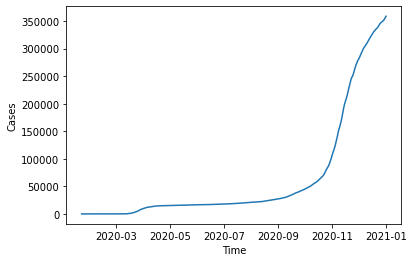

In [5]:
# covid_df["Date"] = covid_df["Date"].apply(lambda d: pd.to_datetime(str(d)))
plt.plot(covid_df["Date"], covid_df['Cases'])
plt.xlabel('Time')
plt.ylabel('Cases')

In [6]:
co_api = "https://api.v2.emissions-api.org/api/v2/carbonmonoxide/average.json?country=AT&begin=2020-01-01&end=2021-01-01"
co_api_key = ""
response = requests.get(co_api + co_api_key)
co_data = response.text

In [7]:
co_df = pd.read_json(co_data) # mol/m^2
co_df['end'] = co_df['end'].map(lambda x: str(x).rstrip('T'))
co_df['start'] = co_df['start'].map(lambda x: str(x).rstrip('T'))
co_df

,average,end,start
0,0.033581,2020-01-01T12:12:19.325000Z,2020-01-01T10:32:22.778000Z
1,0.032566,2020-01-02T11:53:26.264000Z,2020-01-02T11:52:50.145000Z
2,0.030046,2020-01-03T11:34:39.924000Z,2020-01-03T11:34:16.405000Z
3,0.030671,2020-01-04T12:56:09.570000Z,2020-01-04T11:15:36.664000Z
4,0.032008,2020-01-05T12:37:41.111000Z,2020-01-05T10:56:54.645000Z
...,...,...,...
360,0.032924,2020-12-27T12:03:24.073000Z,2020-12-27T12:02:50.474000Z
361,0.032834,2020-12-28T13:24:22.058000Z,2020-12-28T13:24:22.058000Z
362,0.031642,2020-12-29T13:05:46.173000Z,2020-12-29T13:05:07.534000Z
363,0.031613,2020-12-30T12:46:52.408000Z,2020-12-30T12:46:18.808000Z


Text(0, 0.5, 'CO emission')

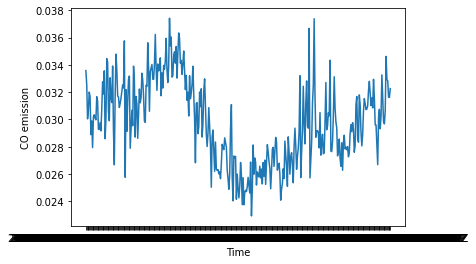

In [8]:
plt.plot(co_df['start'], co_df['average'])
plt.xlabel('Time')
plt.ylabel('CO emission')

ValueError: x and y must have same first dimension, but have shapes (346,) and (365,)

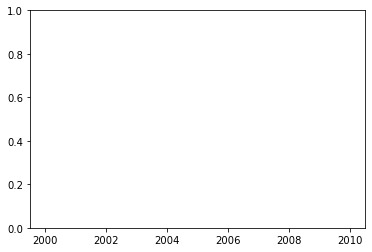

In [9]:
plt.plot(covid_df["Date"], co_df['average'], label="co")
plt.plot(covid_df["Date"], covid_df['Cases'], label="covid")
plt.xlabel('Time')

In [ ]:
# spark = SparkSession.builder.getOrCreate()
# sc = spark.sparkContext
# rddjson = sc.parallelize(jsonStr)
# covid_df2 = spark.read.json(rddjson)
# covid_df2